In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt, sys
import haversine as hs
from csv import reader, writer
import os

In [2]:
num_agents = 4

if os.path.exists('multi_agent.csv') and num_agents > 1:
    os.remove('multi_agent.csv')

if os.path.exists('single_agent.csv') and num_agents == 1:
    os.remove('single_agent.csv')

## Create necessary classes and functions

Create class to handle "cities"

In [3]:
def route_dist(routes):
    distance = 0
    for i in range(0, len(routes) - 1):
        distance += hs.haversine(routes[i].get_coords(), routes[i+1].get_coords(), unit=hs.Unit.METERS)
    return distance

In [4]:
class Hotspot:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, hotspot):
        xDis = abs(self.x - hotspot.x)
        yDis = abs(self.y - hotspot.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def distance_haversine(self, hotspot):
        return hs.haversine((self.x, self.y), (hotspot.x, hotspot.y), unit=hs.Unit.METERS)
    
    def get_coords(self):
        return (self.x, self.y)
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

Create a fitness function

In [5]:
class Fitness:
    def __init__(self, routes):
        self.routes = routes
        self.distance = 0.0
        self.fitness= 0.0
        self.max_dist = 0.0
    
    def routeDistance(self):
        if self.distance ==0.0:
            pathDistance = 0.0
            for i in range(0, len(self.routes)):
                for j in range(0, len(self.routes[i])):
                    fromHotspot = self.routes[i][j]
                    toHotspot = None
                    if j + 1 < len(self.routes[i]):
                        toHotspot = self.routes[i][j + 1]
                    else:
                        toHotspot = self.routes[i][0]
                    pathDistance += fromHotspot.distance_haversine(toHotspot)
            self.distance = pathDistance
        return self.distance
    
    def max_agent_route_dist(self):

        if self.max_dist == 0.0:
            for agent in self.routes:
                dist = route_dist(agent)
                if dist > self.max_dist:
                    self.max_dist = dist
        return self.max_dist
    
    def routeFitness(self):
        if self.fitness == 0:
            penalty = 0
            for agent in range(0, len(self.routes)):
                if len(self.routes[agent]) <= 1 :
                    penalty = float('inf')
                    continue

                if route_dist(self.routes[agent]) > 925:
                    penalty += 1000
                    continue


            self.fitness = 1 / (float(self.routeDistance()) + penalty + self.max_agent_route_dist()*10)
        return self.fitness

Create a drone class 

In [6]:
class Drone:
    def __init__(self, name, flight_time, charge_time, cost, velocity, Altitude):
        self.name = name
        self.flight_time = flight_time
        self.charge_time = charge_time
        self.cost = cost
        self.velocity = velocity
        self.Altitude = Altitude
        self.range = 0

    def set_range(self, range):
        self.range = range

    def validate(self, dist):
        if dist > self.range:
            return False
        else:
            print ("Remaining Flight Time for " + self.name+" : ", ((self.range - dist)/self.velocity)/60)
        return True

In [7]:
def save_data(coord1, coord2, drone_num, time, file_name, cummalative_dist):

    data = [coord1.y, coord1.x, drone_num, coord2.y, coord2.x, time, cummalative_dist]
    with open(file_name, 'a') as file:
        writer_o = writer(file)
        writer_o.writerow(data)

In [8]:
def find_duplicates(list):
    dupes = []
    flat = [ item for sublist in list for item in sublist]
    for x in flat:
        if flat.count(x) > 1 and x not in dupes:
            dupes.append(x)

    if dupes:
        return True
    else:
        return False

## Create our initial population

Route generator

In [9]:
def createRoute(hotspotList, agents):
    totalRoute = random.sample(hotspotList, len(hotspotList))
    routes = []
    j = 0
    for i in range(0, agents - 1):
        j2 = random.randint(j + 1, len(totalRoute)- agents + i)
        routes.append(totalRoute[j: j2])
        j = j2
    routes.append(totalRoute[j: ])
    return routes

Create first "population" (list of routes)

In [10]:
def initialPopulation(popSize, hotspotList, agents):
    population = []
    for i in range(0, popSize):
        population.append(createRoute(hotspotList, agents))
    return population

In [11]:
def get_min_dist(population):
    min_dist = float('inf')
    
    for routes in population:
        fitness = Fitness(routes)
        dist = fitness.routeDistance()
        if dist < min_dist:
            min_dist = dist
    
    return min_dist

def get_max_agent_dist(population):
    
    max_dists = []
    max_idxs = []

    for routes in population:
        max_dist = 0
        for agent in routes:
            dist = route_dist(agent)
            if dist > max_dist:
                max_dist = dist
                max_idxs.append(population.index(routes))
        max_dists.append(max_dist)
        min_dist = min(max_dists)
        min_idx = max_idxs[max_dists.index(min_dist)]
    return min_dist, min_idx


## Create the genetic algorithm

Rank individuals

In [12]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

Create a selection function that will be used to make the list of parent routes

In [13]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Create mating pool

In [14]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

Create a crossover function for two parents to create one child

In [15]:
# Old breed function
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    totalChild = []
    
    routeLengthsParent1 = [0]
    routeLengthsParent2 = [0]
    routeLengthsParent = []
    
    totalParent1 = []
    totalParent2 = []
    
    for i in range(0, len(parent1)):
        routeLengthsParent1.append(len(parent1[i]) + routeLengthsParent1[i])
        routeLengthsParent2.append(len(parent2[i]) + routeLengthsParent2[i])
        totalParent1 = totalParent1 + parent1[i]
        totalParent2 = totalParent2 + parent2[i]
    geneA = int(random.random() * len(totalParent1))
    geneB = int(random.random() * len(totalParent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(totalParent1[i])
        
    childP2 = [item for item in totalParent2 if item not in childP1]

    totalChild = childP1 + childP2
    for i in range(0, len(parent1)):
        routeLengthsParent.append((routeLengthsParent1[i] + routeLengthsParent2[i]) // 2)
    
    routeLengthsParent.append(len(totalChild))
    
    for i in range(0, len(parent1)):
        child.append(totalChild[routeLengthsParent[i]: routeLengthsParent[i + 1]])

    return child


Create function to run crossover over full mating pool

In [16]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

Create function to mutate a single route

In [17]:
# Old mutate function
def mutate(individual, mutationRate):
    totalIndividual = []
    routeLengths = [0]
    for i in range(0, len(individual)):
        totalIndividual = totalIndividual + individual[i]
        routeLengths.append(routeLengths[i] + len(individual[i]))
        
    for swapped in range(len(totalIndividual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(totalIndividual))
            
            hotspot1 = totalIndividual[swapped]
            hotspot2 = totalIndividual[swapWith]
            
            totalIndividual[swapped] = hotspot2
            totalIndividual[swapWith] = hotspot1
    newIndividual = []
    for i in range(0, len(individual)):
        newIndividual.append(totalIndividual[routeLengths[i]: routeLengths[i + 1]])

    
        
    return newIndividual

Create function to run mutation over entire population

In [18]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Put all steps together to create the next generation

In [19]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

Final step: create the genetic algorithm

In [20]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations, agents):
    pop = initialPopulation(popSize, population, agents)
    #print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    print("Initial distance: " + str(get_min_dist(pop)))
    for i in range(0, generations):
        # print(i)
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    # print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    print("Final distance: " + str(get_min_dist(pop)))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

In [21]:
# given a list of cordinates, return the distance from the first to the last
def totalDistance(hotspotList):
    for i in range(0, len(hotspotList) - 1):
        distance += hs.haversine(hotspotList[i], hotspotList[i + 1], unit=hs.Unit.METERS)
    
    return distance


## Running the genetic algorithm

Create list of cities

In [22]:
hotspotList = []
coords = [
    [33.7747760996229, -84.397389045613],                   #Tech Green
    [33.772779872748515, -84.39651065684585],               #Transit Hub
    [33.77357055668125, -84.398009214924],                  #Student Center    
    [33.77688902399273, -84.40366325910463],                #Roe Stamps Field
    [33.77845950552504, -84.40326275302543],                #Burger Bowl Field
    [33.776877666423005, -84.38880262066144],               #Tech Square
    [33.769571690695614, -84.39096887259626],               #North Avenue Apartments
    [33.779599557496205, -84.40469972898788],               #West Village 
    [33.77935960869498, -84.40099513026848],                #Eco Commons
    [33.78123012543277, -84.39378517172695]                 #Ken Bayers Tennis Complex

]

coord_dict = {
    (33.7747760996229, -84.397389045613): "Tech Green",
    (33.772779872748515, -84.39651065684585): "Transit Hub",
    (33.77357055668125, -84.398009214924): "Student Center",
    (33.77688902399273, -84.40366325910463): "Roe Stamps Field",
    (33.77845950552504, -84.40326275302543): "Burger Bowl Field",
    (33.776877666423005, -84.38880262066144): "Tech Square",
    (33.769571690695614, -84.39096887259626): "North Avenue Apartments",
    (33.779599557496205, -84.40469972898788): "West Village",
    (33.77935960869498, -84.40099513026848): "Eco Commons",
    (33.78123012543277, -84.39378517172695): "Ken Bayers Tennis Complex"
}

center = [33.77463127745477, -84.39624207884424]

for i in range(0,len(coords)):
    hotspotList.append(Hotspot(x=coords[i][0], y=coords[i][1]))

In [23]:
#Get dist matrix from list of coordinates
dist_matrix = [[0 for x in range(len(hotspotList))] for y in range(len(hotspotList))]
for i in range(0, len(hotspotList)):
    for j in range(0, len(hotspotList)):
        dist_matrix[i][j] = hs.haversine(hotspotList[i].get_coords(), hotspotList[j].get_coords(), unit=hs.Unit.METERS)

print (dist_matrix)
with open("matrix.csv", 'a') as file:
        writer_o = writer(file)
        for row in dist_matrix:
            writer_o.writerow(row)

[[0.0, 236.3527792357463, 145.79200631368883, 625.6957870463956, 680.0582469888084, 827.3109186876244, 828.8866798883691, 862.6891212598066, 608.9692773065483, 791.1876918225211], [236.3527792357463, 0.0, 164.05971978308946, 803.6372497979614, 887.8787185332704, 845.6923200657911, 624.2194797963126, 1071.413927986358, 840.8855359207572, 972.8076689873673], [145.79200631368883, 164.05971978308946, 0.0, 639.7359262934497, 728.9093145389646, 927.0067136039697, 788.1607354306288, 912.0448815151028, 700.3799044089903, 936.9226559201464], [625.6957870463956, 803.6372497979614, 639.7359262934497, 0.0, 178.51002737595468, 1373.5149157862018, 1427.8545774884428, 316.255503756428, 369.16365044207055, 1032.7276280163092], [680.0582469888084, 887.8787185332704, 728.9093145389646, 178.51002737595468, 0.0, 1348.0095714913107, 1505.9597312915207, 183.599987624392, 232.25523196585902, 928.5458662442544], [827.3109186876244, 845.6923200657911, 927.0067136039697, 1373.5149157862018, 1348.0095714913107, 

Run the genetic algorithm

In [24]:
#geneticAlgorithm(population=hotspotList, popSize=100, eliteSize=2, mutationRate=0.01, generations=100, agents=2)

## Plot the progress

Note, this will win run a separate GA

In [25]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations, agents):
    pop = initialPopulation(popSize, population, agents)
    progress = []
    # best_dist = float('inf')
    # best_route = []
    
    progress.append(1 / rankRoutes(pop)[0][1])
    # val, idx = get_max_agent_dist(pop)
    # progress.append(val)
    # best_route = pop[idx]
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
        # val, idx = get_max_agent_dist(pop)
        # progress.append(val)
        # if val < best_dist:
        #     best_dist = val
        #     best_route = pop[idx]
    #print(pop[rankRoutes(pop)[0][0]])
    #print(1/rankRoutes(pop)[0][1])
    plt.plot(progress)
    plt.ylabel('Inverse of Fitness')
    plt.xlabel('Generation')
    plt.show()
    return (1/rankRoutes(pop)[0][1]), pop[rankRoutes(pop)[0][0]]

In [26]:
def flatten(l):
    return [item for sublist in l for item in sublist]

Run the function with our assumptions to see how distance has improved in each generation

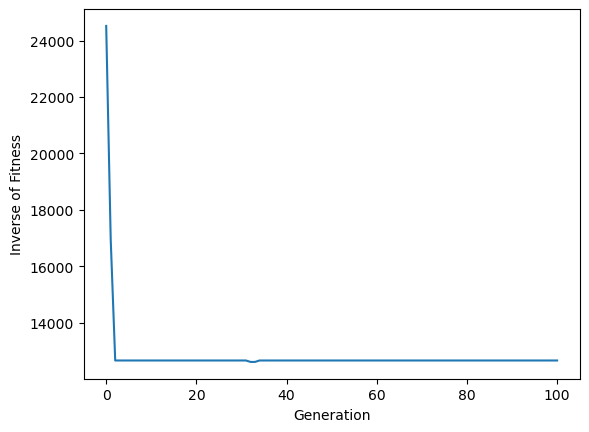

12661.103665563514
[[(33.776877666423005,-84.38880262066144), (33.769571690695614,-84.39096887259626)], [(33.77935960869498,-84.40099513026848), (33.78123012543277,-84.39378517172695)], [(33.779599557496205,-84.40469972898788), (33.77688902399273,-84.40366325910463), (33.77845950552504,-84.40326275302543)], [(33.77357055668125,-84.398009214924), (33.772779872748515,-84.39651065684585), (33.7747760996229,-84.397389045613)]]


In [27]:
final_distance, final_route = geneticAlgorithmPlot(population=hotspotList, popSize=100, eliteSize=20, mutationRate=0.02, generations=100, agents=num_agents)

print (final_distance)
print (final_route)

In [28]:
# print (final_distance)
# print (final_route)
# print (len(final_route))

# final_route = flatten(final_route)

# print (final_route)
# print (len(final_route))

if num_agents > 1:
    filename = f"multi_agent_{num_agents}.csv"
else:
    filename = "single_agent.csv"

for i, drone in enumerate(final_route):
    print("Drone number: ", i)
    for route in drone:
        print (str(route) + " " + str(coords.index([route.x, route.y])))
    

for num, routes in enumerate(final_route):
    #convert list routes to a tuple
    cum_dist = 0  
    for i in range(0, len(routes)-1):
        cum_dist += hs.haversine((routes[i].x, routes[i].y), (routes[i+1].x, routes[i+1].y), unit=hs.Unit.METERS)
        save_data(routes[i], routes[i+1], num, i, filename, cum_dist)
        print("Drone number: ", num, "Time Stamp: ", i, "From: ", coord_dict[(routes[i].x, routes[i].y)], "To: ", coord_dict[(routes[i+1].x, routes[i+1].y)], "Distance: ", cum_dist)

drone_dist = []

for i, drone in enumerate(final_route):
    dist = 0
    for j in range(0, len(drone)-1):
        dist += hs.haversine((drone[j].x, drone[j].y), (drone[j+1].x, drone[j+1].y), unit=hs.Unit.METERS)
    drone_dist.append(dist)

print(drone_dist)
        
        

Drone number:  0
(33.776877666423005,-84.38880262066144) 5
(33.769571690695614,-84.39096887259626) 6
Drone number:  1
(33.77935960869498,-84.40099513026848) 8
(33.78123012543277,-84.39378517172695) 9
Drone number:  2
(33.779599557496205,-84.40469972898788) 7
(33.77688902399273,-84.40366325910463) 3
(33.77845950552504,-84.40326275302543) 4
Drone number:  3
(33.77357055668125,-84.398009214924) 2
(33.772779872748515,-84.39651065684585) 1
(33.7747760996229,-84.397389045613) 0
Drone number:  0 Time Stamp:  0 From:  Tech Square To:  North Avenue Apartments Distance:  836.6995458189502
Drone number:  1 Time Stamp:  0 From:  Eco Commons To:  Ken Bayers Tennis Complex Distance:  698.0695458234073
Drone number:  2 Time Stamp:  0 From:  West Village To:  Roe Stamps Field Distance:  316.255503756428
Drone number:  2 Time Stamp:  1 From:  Roe Stamps Field To:  Burger Bowl Field Distance:  494.7655311323827
Drone number:  3 Time Stamp:  0 From:  Student Center To:  Transit Hub Distance:  164.0597197

In [29]:
def validate_drones(drones, dist):
    output = []
    for drone in drones:
        if drone.validate(dist):
            output.append(drone)
    return output

In [30]:
altaX = Drone("AltaX", 35, 2, 18200, 26.3, 8000)
dji_M_30 = Drone("DJI Matrice 30", 40, 0.7, 14700, 23, 7000)
dji_M_600 = Drone("DJI Matrice 600", 25, 1.2, 11000, 18, 4500)
dji_P_4 = Drone("DJI Phantom 4", 20, 0.8, 1599, 14, 6000)

drone_list = [dji_M_30, dji_M_600, dji_P_4, altaX]

sensing_time = 1 #minute
sensing_time = sensing_time* 10
Takeoff_Landing_time = 5 #minute

vel_percent = 0.7

for drone in drone_list:
    range = (drone.flight_time - (sensing_time+Takeoff_Landing_time))*drone.velocity*vel_percent*60
    drone.set_range(range)
    print(drone.name + " has a range of " + str(range) + " meters")

for dists in drone_dist:
    valid_drones = validate_drones(drone_list, dist)
    print("Final distance: " + str(dist))
    print("Valid drones: ")
    for drone in valid_drones:
        print(drone.name)


DJI Matrice 30 has a range of 24150.0 meters
DJI Matrice 600 has a range of 7559.999999999999 meters
DJI Phantom 4 has a range of 2940.0 meters
AltaX has a range of 22092.0 meters
Remaining Flight Time for DJI Matrice 30 :  17.209846015203745
Remaining Flight Time for DJI Matrice 600 :  6.629247686093669
Remaining Flight Time for DJI Phantom 4 :  3.023318453549005
Remaining Flight Time for AltaX :  13.746253169189583
Final distance: 400.4124990188358
Valid drones: 
DJI Matrice 30
DJI Matrice 600
DJI Phantom 4
AltaX
Remaining Flight Time for DJI Matrice 30 :  17.209846015203745
Remaining Flight Time for DJI Matrice 600 :  6.629247686093669
Remaining Flight Time for DJI Phantom 4 :  3.023318453549005
Remaining Flight Time for AltaX :  13.746253169189583
Final distance: 400.4124990188358
Valid drones: 
DJI Matrice 30
DJI Matrice 600
DJI Phantom 4
AltaX
Remaining Flight Time for DJI Matrice 30 :  17.209846015203745
Remaining Flight Time for DJI Matrice 600 :  6.629247686093669
Remaining Fl